### Phase 1: Hydrogen


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

from qat.qpus import get_default_qpu
from qat.core import Batch, Job

from qat.fermion.transforms import transform_to_jw_basis
from qat.fermion.hamiltonians import make_embedded_model
from qat.fermion.circuits import make_shallow_circ, make_ldca_circ

from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation
from qat.fermion.chemistry import MolecularHamiltonian, MoleculeInfo
from qat.fermion.trotterisation import make_trotterisation_routine
from qat.fermion.chemistry.ucc import construct_ucc_ansatz, guess_init_params, get_hf_ket, get_cluster_ops
from qat.qpus import get_default_qpu

from qat.plugins import ScipyMinimizePlugin, MultipleLaunchesAnalyzer

In [2]:
from openvqe.common_files import molecule_factory

In [3]:
from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation

geometry = [("H", (0.0, 0.0, 0.0)), ("H", (0.0, 0.0, 0.7414))]
basis = "sto-3g"
spin = 0
charge = 0

(
    rdm1,
    orbital_energies,
    nuclear_repulsion,
    n_electrons,
    one_body_integrals,
    two_body_integrals,
    info,
) = perform_pyscf_computation(geometry=geometry, basis=basis, spin=spin, charge=charge, run_fci=True)

print(
    f" HF energy :  {info['HF']}\n",
    f"MP2 energy : {info['MP2']}\n",
    f"FCI energy : {info['FCI']}\n",
)
print(f"Number of qubits before active space selection = {rdm1.shape[0] * 2}")

nqbits = rdm1.shape[0] * 2
print("Number of qubits = ", nqbits)

 HF energy :  -1.1166843870853405
 MP2 energy : -1.1298551535553094
 FCI energy : -1.137270174660903

Number of qubits before active space selection = 4
Number of qubits =  4


/home/huybinh/.local/lib/python3.10/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [4]:
mol_h = MolecularHamiltonian(one_body_integrals, two_body_integrals, nuclear_repulsion)
H = mol_h.get_electronic_hamiltonian()

In [5]:
from qat.fermion.transforms import transform_to_jw_basis, transform_to_parity_basis, transform_to_bk_basis

# Using the Jordan-Wigner transform
hamiltonian_sp = transform_to_jw_basis(H)
# Using the Bravyi-Kitaev transform
# H_spin = transform_to_bk_basis(H)
# Using the parity transform
#H_spin = transform_to_parity_basis(H_fermion)
model = hamiltonian_sp
print(model)

(-0.09886396933545827+0j) * I^4 +
(0.1686221915892095+0j) * (ZZ|[0, 1]) +
(0.12054482205301797+0j) * (ZZ|[0, 2]) +
(0.165867024105892+0j) * (ZZ|[1, 2]) +
(0.165867024105892+0j) * (ZZ|[0, 3]) +
(0.17119774903432972+0j) * (Z|[0]) +
(0.12054482205301797+0j) * (ZZ|[1, 3]) +
(0.17119774903432972+0j) * (Z|[1]) +
(0.045322202052874+0j) * (XYYX|[0, 1, 2, 3]) +
(-0.045322202052874+0j) * (XXYY|[0, 1, 2, 3]) +
(-0.045322202052874+0j) * (YYXX|[0, 1, 2, 3]) +
(0.045322202052874+0j) * (YXXY|[0, 1, 2, 3]) +
(0.17434844185575687+0j) * (ZZ|[2, 3]) +
(-0.22278593040418468+0j) * (Z|[2]) +
(-0.22278593040418468+0j) * (Z|[3])


In [6]:
print(model.nbqbits)

4


In [7]:
model_matrix_sp = model.get_matrix(sparse=True)
from scipy.sparse.linalg import eigsh
eigval, eigvec = eigsh(model_matrix_sp, k=1)

In [8]:
print(eigval)

[-1.13727017]


In [9]:
print(eigvec)

[[ 4.50472447e-16+9.25547445e-19j]
 [ 2.46104683e-16+2.36110269e-16j]
 [-2.74449675e-17+6.88234119e-17j]
 [-1.05281812e-01+4.05679088e-02j]
 [-2.12245918e-17+6.18402494e-17j]
 [-9.91420919e-17-7.85170033e-17j]
 [ 1.85722496e-16+1.87362885e-16j]
 [ 3.69445302e-17-5.71729503e-17j]
 [ 9.41955112e-17+7.06649433e-18j]
 [-3.16912094e-17-1.12796848e-16j]
 [ 1.51352225e-16-8.43852000e-17j]
 [ 3.76366550e-17-1.04782954e-16j]
 [ 9.27164634e-01-3.57261427e-01j]
 [-2.45091449e-17+1.49139666e-16j]
 [ 1.54212074e-16-2.49922469e-16j]
 [-1.80031553e-16+1.42952640e-16j]]


In [10]:
# To write circuits
from qat.lang.AQASM import *
from qat.lang import Program
# To define an observable
from qat.core import Observable, Term
# our Plugin
from qat.plugins import ObservableSplitter
# and a QPU
from qat.qpus import get_default_qpu
from qat.interop.qiskit import qlm_to_qiskit

#### Step 2: Creat 4 initial states manually from creating the circuit gates b

Box State: 0000, Value: 0, Excitation: 0.7137539936876182
Box State: 0001, Value: 1, Excitation: 0.23780527846665372
Box State: 0010, Value: 2, Excitation: 0.23780527846665367
Box State: 0100, Value: 4, Excitation: -0.5387095798772803
Box State: 1000, Value: 8, Excitation: -0.5387095798772803
Box State: 0011, Value: 3, Excitation: 0.459250330668717
Box State: 0101, Value: 5, Excitation: -0.5324790068861727
Box State: 1001, Value: 9, Excitation: -0.3511901986746766
Box State: 0110, Value: 6, Excitation: -0.3511901986746766
Box State: 1010, Value: 10, Excitation: -0.5324790068861727
Box State: 1100, Value: 12, Excitation: -1.1166843870853407
Box State: 0111, Value: 7, Excitation: 0.3524341417394585
Box State: 1011, Value: 11, Excitation: 0.3524341417394585
Box State: 1101, Value: 13, Excitation: -0.4469857176706651
Box State: 1110, Value: 14, Excitation: -0.4469857176706651
Box State: 1111, Value: 15, Excitation: 0.920106719167038


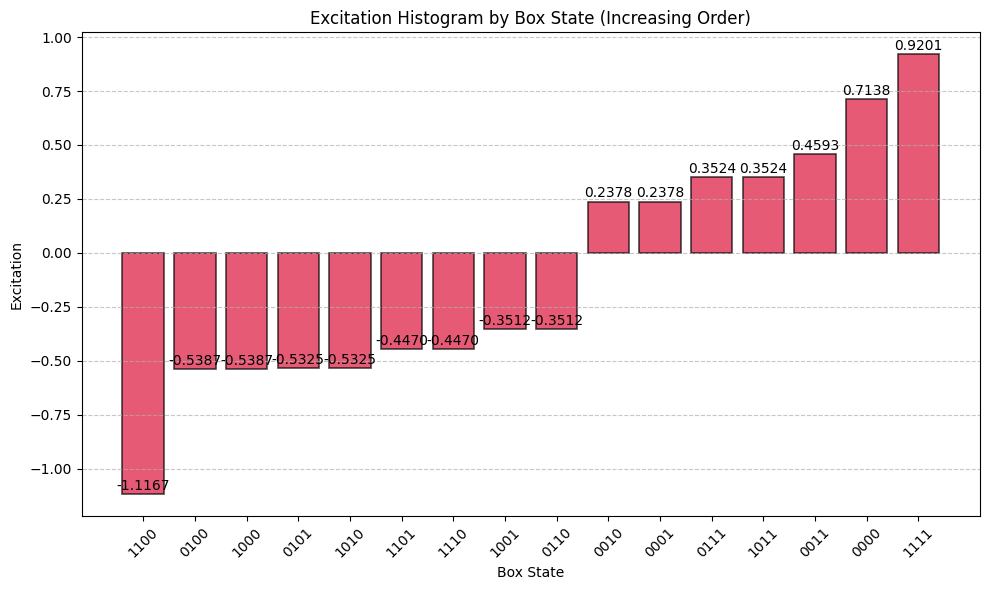

In [11]:
import matplotlib.pyplot as plt
from numpy import binary_repr
from qat.lang import Program, X
from qat.qpus import get_default_qpu

# Assuming hamiltonian_sp is defined somewhere in your code
# and box_list contains the values you mentioned
box_list = [0, 1, 2, 4, 8, 3, 5, 9, 6, 10, 12, 7, 11, 13, 14, 15]


def create_program(value, nqbits):
    ket_value = binary_repr(value)
    padded_ket_value = ket_value.zfill(nqbits)  # Pad with zeros to the left
    list_ket_value = [int(c) for c in padded_ket_value]

    prog = Program()
    qb = prog.qalloc(nqbits)

    # Apply X gates based on the binary representation of the current value
    for j in range(min(nqbits, len(list_ket_value))):
        if list_ket_value[j] == 1:
            prog.apply(X, qb[j])

    return prog


excitation_values = []
box_states = []

for value in box_list:
    nqbits = model.nbqbits
    prog = create_program(value, nqbits)

    circ = prog.to_circ()
    qpu = get_default_qpu()

    # Assuming hamiltonian_sp is defined somewhere in your code
    job = circ.to_job(job_type="OBS", observable=model)
    res = qpu.submit(job)

    box_states.append(binary_repr(value, width=nqbits))
    excitation_values.append(res.value)

    # Print the box state and the result for each value
    print(f"Box State: {binary_repr(value, width=nqbits)}, Value: {value}, Excitation: {res.value}")

# Sorting the data by excitation values
sorted_data = sorted(zip(box_states, excitation_values), key=lambda x: x[1])

# Extracting sorted box states and excitation values
sorted_box_states, sorted_excitation_values = zip(*sorted_data)

# Plotting histogram with a larger figure size, crimson color, and a different style
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
bars = plt.bar(sorted_box_states, sorted_excitation_values, color='crimson', alpha=0.7, edgecolor='black', linestyle='-', linewidth=1.2)
plt.xlabel('Box State')
plt.ylabel('Excitation')
plt.title('Excitation Histogram by Box State (Increasing Order)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text annotations on top of each bar
for bar, excitation in zip(bars, sorted_excitation_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f'{excitation:.4f}', ha='center', va='bottom')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


From this graph, I decided the three exact values 
-  Ground state 1001 with k=12 
- The first excited state 0100 with k=4 
- The second excited state 1101 with k=13
- The third excited state 0110 with k= 6

#### Step 3: Try to find the way to generate the initial state 

In [12]:
from numpy import binary_repr

from qat.lang import Program, H, X, Y, Z, I, PH, S, T, RX, RY, RZ, CNOT, ISWAP, SQRTSWAP, CCNOT, SWAP

from qat.interop.qiskit import qlm_to_qiskit
import matplotlib as mpl


def inst(nqbits, k):
    prog= Program()
    state = binary_repr(k)
    state_pad = state.zfill(nqbits)
    state_lst = [int(c) for c in state_pad]
    reg = prog.qalloc(nqbits)

    for j in range(min(nqbits, len(state_lst))):
        if int(state_lst[j] == 1):
            prog.apply(X, reg[j])

    circ = prog.to_circ()
    
    qpu = get_default_qpu()
    job = circ.to_job(job_type="OBS", observable=model)
    res = qpu.submit(job)
    print("This state is ", state_pad)
    print("The value of this state is applying on the Ising model:", res.value)
    return res.value



#print(k) = 12
# print(state) = 1100
# print(state_lst) = [1, 1, 0, 0]

# Basically we have the number 12 and its binary for it will be 1100 so if I have 

def inst_drw(nqbits, k):
    prog= Program()
    state = binary_repr(k)
    state_pad = state.zfill(nqbits)
    state_lst = [int(c) for c in state_pad]
    reg = prog.qalloc(nqbits)

    for j in range(min(nqbits, len(state_lst))):
        if int(state_lst[j] == 1):
            prog.apply(X, reg[j])
        
        if int(state_lst[j] == 0):
            prog.apply(I, reg[j])

    return prog.to_circ()






In [13]:
# This is for only the getting idea
init_state = inst(model.nbqbits, 0)

init_state_drw = inst_drw(model.nbqbits, 0)

init_state_drw.display()


This state is  0000
The value of this state is applying on the Ising model: 0.7137539936876182


#### Step 4: Create the circuit as the template of the strong layered U draft

In [14]:
from qat.lang.AQASM import Program, QRoutine, RY, CNOT, RX, Z, H, RZ
prog = Program()
reg = prog.qalloc(nqbits)
theta = [prog.new_var(float, '\\theta_%s'%i)
         
         for i in range(nqbits * 2)]
for ind in range(nqbits):
    RX(theta[ind])(reg[ind])
    RZ(theta[ind])(reg[ind])

for qb in range(nqbits-1):
    CNOT(reg[qb], reg[(qb+1)%nqbits])

for ind in range(nqbits, 2*nqbits):
    RX(theta[ind])(reg[ind - nqbits])
    RZ(theta[ind])(reg[ind - nqbits])

circ = prog.to_circ()
circ.display()

#### Step 5: Construct the ansatz circuit $U(\theta)$

In [15]:
from qat.lang.AQASM import Program, QRoutine, RY, CNOT, RX, Z, H, RZ, I
from qat.core import Observable, Term, Circuit
from qat.lang.AQASM.gates import Gate
import matplotlib as mpl
import numpy as np
from typing import Optional, List
import warnings

In [16]:
#Without any initial state
def U_init(
    nqbits: int,
    #theta: List[float],
    n_layers: int = 1,
    rotation_gates: List[Gate] = None,
    entangling_gate: Gate = CNOT,
) -> Circuit: #linear entanglement


    if rotation_gates is None:
        rotation_gates = [RZ]

    n_rotations = len(rotation_gates)

    prog = Program()
    reg = prog.qalloc(nqbits)
    theta = [prog.new_var(float, rf"\theta_{{{i}}}") for i in range(n_rotations * (nqbits + 2 * (nqbits - 1) * n_layers))]
    
    
    ind_theta = 0


    
    for i in range(nqbits):

        for rot in rotation_gates:

            prog.apply(rot(theta[ind_theta]), reg[i])
            ind_theta += 1
    
    for k in range(n_layers):


        for i in range(nqbits - 1):
            prog.apply(CNOT, reg[i], reg[i+1])
            
        for i in range(nqbits):
            for rot in rotation_gates:
                            
                prog.apply(rot(theta[ind_theta]), reg[i])
                ind_theta += 1

    return prog.to_circ()

In [17]:

circ_init = U_init(4, 3, [RX,RZ], CNOT)
circ_init.display()


This structure below showing the circuit U with initial state as 1001 with k = 9

In [18]:
#With initial state
def U_theta(
    nqbits: int,
    theta: List[float],
    k_init: int,
    n_layers: int = 1,
    rotation_gates: List[Gate] = None,
    entangling_gate: Gate = CNOT,
) -> Circuit: #linear entanglement

    prog = Program()
    reg = prog.qalloc(nqbits)
    
    
    state = binary_repr(k_init)
    state_pad = state.zfill(nqbits)
    state_lst = [int(c) for c in state_pad]


    for j in range(min(nqbits, len(state_lst))):
        if int(state_lst[j] == 1):
            prog.apply(X, reg[j])
        
        if int(state_lst[j] == 0):
            prog.apply(I, reg[j])
    
    print("This initial state is ", state_pad)
    
    
    
    
    if rotation_gates is None:
        rotation_gates = [RZ]

    n_rotations = len(rotation_gates)

    theta = [prog.new_var(float, rf"\theta_{{{i}}}") for i in range(n_rotations * (nqbits + 2 * (nqbits - 1) * n_layers))]
    
    
    ind_theta = 0


    
    for i in range(nqbits):

        for rot in rotation_gates:

            prog.apply(rot(theta[ind_theta]), reg[i])
            ind_theta += 1
    
    for k in range(n_layers):


        for i in range(nqbits - 1):
            prog.apply(CNOT, reg[i], reg[i+1])
            
        for i in range(nqbits):
            for rot in rotation_gates:
                            
                prog.apply(rot(theta[ind_theta]), reg[i])
                ind_theta += 1
    

    return prog.to_circ()

In [19]:
#Give the previous value for pluging in the theta
n_rotations = 2
nqbits =4
n_layers = 3
k= 9

theta_0 = [np.random.uniform(0, 2*np.pi) for i in range(n_rotations * (nqbits + 2 * (nqbits - 1) * n_layers))]
print("Value that will be distribute to all the indicator of theta as initial state are :", theta_0)
# k = 9 will generate the the initial state

circ_theta = U_theta(4, theta_0, 12, 3, [RX,RZ], CNOT)
circ_theta.display()

Value that will be distribute to all the indicator of theta as initial state are : [5.85998687818607, 4.035857019123035, 2.986781255886074, 2.0509345857489643, 0.07177104216971526, 6.062338966762577, 3.712540423446683, 6.120588280743014, 1.931568913326926, 1.4962433073763035, 2.32232799153051, 2.6800206915813125, 1.0219055983465204, 3.523708799574864, 2.8526396234245874, 4.547615435540978, 5.390785762014988, 3.566134643859401, 4.230550628574139, 2.7768479244096365, 4.614243009813707, 5.019926880284218, 1.7933989025337154, 4.887139700081177, 5.25302338113999, 0.6119963071319482, 1.7828828724313988, 0.42453386805958365, 1.2408131818081247, 5.596690371170934, 1.0108624536646693, 6.066672197347755, 4.973611698804785, 0.7985396130871741, 0.5083788215423977, 5.795102844213738, 5.572122293733178, 4.156855433414916, 2.1904854548943544, 2.043806595036856, 5.033499082369567, 0.7868791563007561, 3.5010398409523282, 1.126345147581094]
This initial state is  1100


In [20]:
print("The number of the distributed parameter theta: " ,len(theta_0))

The number of the distributed parameter theta:  44


#### Step 6: Measurement for the U_theta using optimizer 

In [21]:
import numpy
from qat.vsolve.optimize import ScipyMinimizePlugin
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qat.qpus import get_default_qpu

methods = ["COBYLA", "Nelder-Mead", "BFGS"]

Optimizer = ScipyMinimizePlugin( method="BFGS", 
                                 x0 = theta_0,
                                 tol=1e-6,
                                 options={"maxiter": 200, "disp": True},
                                 )


"""   
# Here again initial parameters are randomly chosen and a list of method can be used in the future 
methods = ["COBYLA", "BFGS", "PSO", "SPSA"]
plugins = {
    "COBYLA": ScipyMinimizePlugin(method="COBYLA", x0=x0),
    "BFGS": ScipyMinimizePlugin(method="BFGS", x0=x0),
    "PSO": PSOMinimizePlugin(),
    "SPSA": SPSAMinimizePlugin(x0=x0),
}
for method in methods:
    stack = plugins[method] | qpu
    res[method] = stack.submit(circ.to_job(job_type="OBS", observable=obs))

"""


qpu = get_default_qpu()
stack = Optimizer | qpu


job_theta = circ_theta.to_job(job_type="OBS",
                  observable=model,
                  nbshots=0)

res_theta = stack.submit(job_theta)
# Define termms for the measurments
xlist_U = res_theta.value
ylist_U = res_theta.meta_data["parameters"]
vals_U = res_theta.meta_data["optimization_trace"]
trace_U = eval(vals_U)
data_U =  res_theta.meta_data["optimizer_data"]

print("Optimization energy Result:", xlist_U)
print("The optimization data:", data_U)
print("Theta optimization updated", ylist_U)
print("Evaluated energy for each optimized step",trace_U)
print(vals_U)
# Actually everything is in the optimizer_data

Optimization terminated successfully.
         Current function value: -1.137270
         Iterations: 57
         Function evaluations: 2610
         Gradient evaluations: 58
Optimization energy Result: -1.137270174541461
The optimization data:   message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -1.137270174541461
        x: [ 6.283e+00  3.091e+00 ...  3.142e+00  8.363e-01]
      nit: 57
      jac: [-1.192e-07  2.980e-08 ...  1.043e-07  4.470e-08]
 hess_inv: [[ 1.141e+00 -2.285e-01 ...  2.523e-01 -7.374e-02]
            [-2.285e-01  3.808e+01 ... -2.060e-01  9.999e+00]
            ...
            [ 2.523e-01 -2.060e-01 ...  2.417e+00 -1.498e-01]
            [-7.374e-02  9.999e+00 ... -1.498e-01  3.885e+00]]
     nfev: 2610
     njev: 58
Theta optimization updated [6.2831849635433175, 3.0905163991146596, 2.431538475220324, 0.6263923516191556, 0.9923795955632579, 6.120711546741464, 4.412356701118476, 6.509321180132443, 1.3456679483179015, 0.0972769482

In [22]:
#Storing information

iterations_U_theta = {
    "minimum_energy_result": [],
    "theta_optimized_result": [],
    "energy_optimized_result": [],
}



iterations_U_theta["minimum_energy_result"].append(xlist_U) 
iterations_U_theta["theta_optimized_result"].append(ylist_U)
iterations_U_theta["energy_optimized_result"].append(trace_U)

print(iterations_U_theta)

{'minimum_energy_result': [-1.137270174541461], 'theta_optimized_result': ['[6.2831849635433175, 3.0905163991146596, 2.431538475220324, 0.6263923516191556, 0.9923795955632579, 6.120711546741464, 4.412356701118476, 6.509321180132443, 1.3456679483179015, 0.0972769482208742, 2.976574956366058, 2.575333916950168, 1.5192738020853633, 3.32462637556308, 2.5199267837364916, 3.3446756756530105, 3.14159376044079, 3.6099308428180827, 3.3062753614186464, 3.0146743400345044, 4.3343489083634, 4.976127298264654, 2.9479188647711037, 4.71175688688713, 5.01519565546624, 0.611997063934807, 1.7828832543487507, 0.4245341576656506, 1.240813369573689, 5.596690724341225, 1.0108631995102353, 6.0666722939476685, 4.973612154874877, -0.5930372890970654, 0.5083796076306377, 5.7951035501548525, 5.572122816642053, 4.156855511636119, 1.420067698139093, 3.3647311929537986, 5.295394521006126, 0.2102940782096924, 3.141596215382322, 0.8362944431500262]'], 'energy_optimized_result': [[-0.08625189302511367, -0.086251894387

Optimization terminated successfully.
         Current function value: -1.137270
         Iterations: 56
         Function evaluations: 2565
         Gradient evaluations: 57


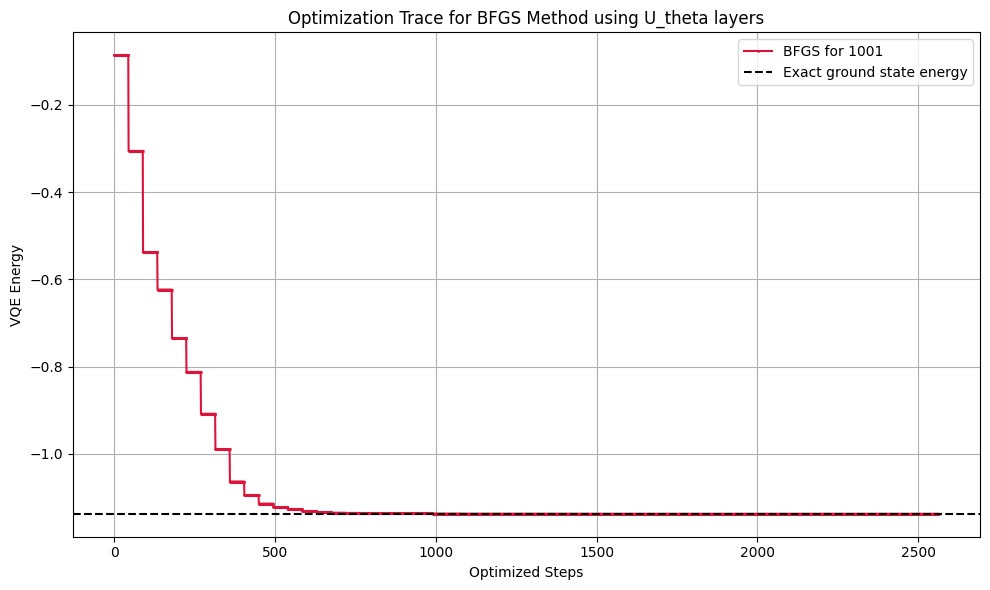

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming stack, job_theta, and job_funct are already defined

# Plot the optimization trace for BFGS from job_theta
res_theta = stack.submit(job_theta)
vals_U = res_theta.meta_data["optimization_trace"]
trace_U = eval(vals_U)
trace_U = trace_U[:3500]
xlist_U = res_theta.value

plt.figure(figsize=(10, 6))

# Plot the trace_U
plt.plot(
    trace_U,
    lw=1.5,
    label="BFGS for 1001",
    color='crimson',
    linestyle='solid',
    marker='3',
    markersize=2.2
)


plt.axhline(xlist_U, color='black', linestyle='--', label="Exact ground state energy")

plt.xlabel("Optimized Steps")
plt.ylabel("VQE Energy")
plt.legend()
plt.grid(True)
plt.title("Optimization Trace for BFGS Method using U_theta layers")
plt.tight_layout()
plt.show()



In [24]:
"""
#### This is the plot for the three method

theta_0 = [np.random.uniform(0, 2*np.pi) for i in range(n_rotations * (nqbits + 2 * (nqbits - 1) * n_layers))]

linalg_qpu = get_default_qpu()

# List of optimization methods
methods = ["COBYLA", "Nelder-Mead", "BFGS"]

# Define custom markers for each method
markers = ['1', '2', '3']

# Dictionary to store results for each method
result = {}

# Perform optimization for each method
for method in methods:
    optimizer_scipy = ScipyMinimizePlugin(
        method=method,
        tol=1e-6,
        options={"maxiter": 200},
        x0=theta_0
    )
     # Set up the quantum processing pipeline
    qpu = optimizer_scipy | linalg_qpu
    
    # Submit the job for optimization
    result[method] = qpu.submit(job_theta)
    
    print("Minimum VQE energy (%s) = %s" % (method, result[method].value))

# Set the figure size to a larger value
plt.figure(figsize=(10, 6))


# Define colors and line styles for the plots
colors = ['firebrick', 'darkorange', 'darkgreen']
linestyles = ['dashdot', 'dotted', 'solid']

# Create plots for optimization traces of all methods
for i, method in enumerate(methods):
    trace = eval(result[method].meta_data["optimization_trace"])
    label = method
    plt.plot(
        trace,
        lw=1.5,
        label=label,
        color=colors[i],
        linestyle=linestyles[i],
        marker=markers[i],  # Custom marker for each method
        markersize=2.2  # Adjust marker size as needed
    )

plt.xlabel("Optimized Steps")
plt.ylabel("VQE Energy")
plt.legend()
plt.grid(True)
plt.title("Optimization Trace Comparison for Different Methods using U_theta for 0010")
plt.tight_layout()  # Improve layout for better spacing
plt.show()

"""


'\n#### This is the plot for the three method\n\ntheta_0 = [np.random.uniform(0, 2*np.pi) for i in range(n_rotations * (nqbits + 2 * (nqbits - 1) * n_layers))]\n\nlinalg_qpu = get_default_qpu()\n\n# List of optimization methods\nmethods = ["COBYLA", "Nelder-Mead", "BFGS"]\n\n# Define custom markers for each method\nmarkers = [\'1\', \'2\', \'3\']\n\n# Dictionary to store results for each method\nresult = {}\n\n# Perform optimization for each method\nfor method in methods:\n    optimizer_scipy = ScipyMinimizePlugin(\n        method=method,\n        tol=1e-6,\n        options={"maxiter": 200},\n        x0=theta_0\n    )\n     # Set up the quantum processing pipeline\n    qpu = optimizer_scipy | linalg_qpu\n    \n    # Submit the job for optimization\n    result[method] = qpu.submit(job_theta)\n    \n    print("Minimum VQE energy (%s) = %s" % (method, result[method].value))\n\n# Set the figure size to a larger value\nplt.figure(figsize=(10, 6))\n\n\n# Define colors and line styles for the

In [25]:
opt_circ_U = circ_theta.bind_variables(eval(res_theta.meta_data["parameter_map"]))
job_opt_U = opt_circ_U.to_job()

from qat.qpus import get_default_qpu

# Evaluate the job and print the output probabilities
result = get_default_qpu().submit(job_opt_U)
for sample in result:
    print(sample.state, sample.probability)

|0000> 4.08801990780775e-17
|0001> 1.1178857841224007e-13
|0010> 6.428134907368284e-14
|0011> 0.012729944372007532
|0100> 2.356110519322331e-13
|0101> 3.5460252929519013e-13
|0110> 3.4255940494664803e-12
|0111> 2.4420999339348947e-13
|1000> 1.0910822469405107e-11
|1001> 5.469210927430907e-11
|1010> 5.6430825445360295e-11
|1011> 1.374076807554511e-12
|1100> 0.9872700554926932
|1101> 1.2091562404804785e-12
|1110> 5.923201630106219e-12
|1111> 3.223548060742915e-13


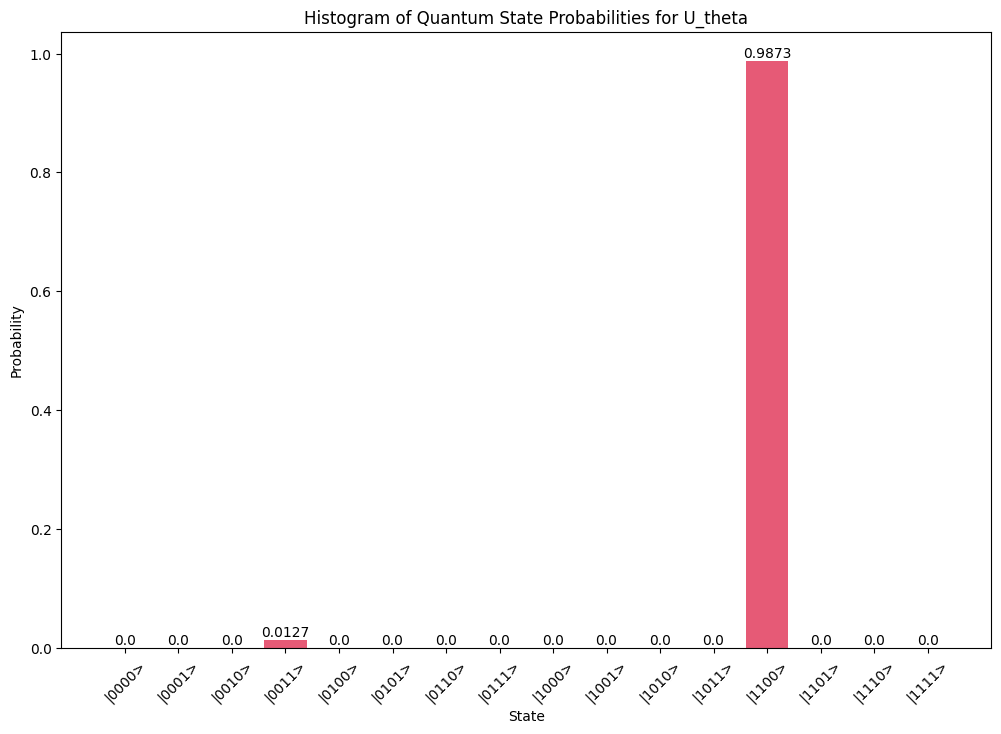

In [26]:
import matplotlib.pyplot as plt

# Assuming you already have opt_circ_U, job_opt_U, and result as defined in your code

# Evaluate the job and collect the output probabilities
result = get_default_qpu().submit(job_opt_U)
output_states = [str(sample.state) for sample in result]
probabilities = [sample.probability for sample in result]

# Plotting the histogram with a larger figure size
plt.figure(figsize=(12, 8))
bars = plt.bar(output_states, probabilities, align='center', alpha=0.7, color='crimson')
plt.xlabel('State')
plt.ylabel('Probability')
plt.xticks(rotation=45)
plt.title('Histogram of Quantum State Probabilities for U_theta')

# Annotate each bar with its value on top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, round(yval, 4), ha='center', va='bottom')

plt.show()









#### Step 6: Construct the ansatz circuit $V(\phi)$ to target the excited state 0100 where k= 4

In [27]:
# Contruct without the target state
def V_init(
    nqbits: int,
    n_cycles: int = 1,
    rotation_gates: List[Gate] = None,
    entangling_gate: Gate = CNOT,
) -> Circuit:
    if rotation_gates is None:
        rotation_gates = [RZ]

    n_rotations = len(rotation_gates)

    prog = Program()
    reg = prog.qalloc(nqbits)
    phi = [prog.new_var(float, rf"\phi_{{{i}}}") for i in range(n_rotations * (nqbits + 2 * (nqbits - 1) * n_cycles))]

    ind_phi = 0



    for k in range(n_cycles):
    # Apply rotational gates from qubit 2 to nqbits - 1




        for i in range(nqbits//2, nqbits):
            for rot in rotation_gates:
                prog.apply(rot(phi[ind_phi]), reg[i])
                ind_phi += 1
    

        # Apply CNOT gates from qubit 2 to nqbits - 2
        for i in range(nqbits//2, nqbits - 1):
            prog.apply(entangling_gate, reg[i], reg[i + 1])


    return prog.to_circ()


In [28]:
circ_init = V_init(4, 1, [RX,RZ], CNOT)
circ_init.display()

In [29]:

def V_phi(
    nqbits: int,
    phi: List[float],
    n_cycles: int = 1,
    k_targ: int=1,
    rotation_gates: List[Gate] = None,
    entangling_gate: Gate = CNOT,
) -> Circuit:
    prog = Program()
    reg = prog.qalloc(nqbits)
    
    state = binary_repr(k_targ)
    state_pad = state.zfill(nqbits)
    state_lst = [int(c) for c in state_pad]

    for j in range(min(nqbits, len(state_lst))):
        if int(state_lst[j] == 1):
            prog.apply(X, reg[j])
        if int(state_lst[j] == 0):
            prog.apply(I, reg[j])
    
    print("This targer state is ", state_pad)

    if rotation_gates is None:
        rotation_gates = [RZ]

    n_rotations = len(rotation_gates)

    phi = [prog.new_var(float, rf"\phi_{{{i}}}") for i in range(n_rotations * (nqbits + 2 * (nqbits - 1) * n_cycles))]
    ind_phi = 0

    for k in range(n_cycles):


        # Apply rotational gates from qubit nqbits//2 to nqbits - 1
        for i in range(nqbits//2, nqbits):
            for rot in rotation_gates:
                prog.apply(rot(phi[ind_phi]), reg[i])
                ind_phi += 1

        # Apply CNOT gates from qubit nqbits//2 to nqbits - 2
        for i in range(nqbits//2, nqbits - 1):
            prog.apply(entangling_gate, reg[i], reg[i + 1])

        # Reset ind_phi for the next cycle
        ind_phi = 0

    return prog.to_circ()

In [30]:
n_rotations = 2
nqbits =4
n_cycles = 3
k_targ = 4

phi_0 = [np.random.uniform(0, 2*np.pi) for i in range(n_rotations * (nqbits + 2 * (nqbits - 1) * n_cycles))]
print("Values that will be distribute to all the indicator of phi as applied state are :", phi_0)

circ_phi = V_phi(4, phi_0, 3, 4, [RX,RZ], CNOT)
circ_phi.display()

Values that will be distribute to all the indicator of phi as applied state are : [5.522751166853798, 5.599088022200775, 3.6281611806025102, 2.1901136955221654, 5.621611124182165, 4.384230001421599, 4.280420223270331, 0.11466823906322178, 3.2138995177314804, 2.3192164694204864, 2.4325062280154754, 0.3110486048492636, 3.499790102218165, 1.197970336855734, 1.3511709644451542, 4.040912732237682, 0.08429890443465442, 2.0871014027939725, 2.9994296793478568, 1.1297653253131679, 0.06936423219317336, 3.215296779783037, 2.824535305317421, 2.538642962337917, 3.576002686366637, 6.276897222264828, 5.327938139478606, 4.036101180868183, 1.563664984490538, 0.5555062404884621, 0.5562434997728506, 2.3273415277582985, 0.9775176338571316, 2.831936110879576, 2.883856026510494, 2.9976753426377964, 4.252358024786958, 2.630042674477683, 5.1114538399510066, 6.221298521728811, 3.67652401675257, 3.232259943941992, 1.0105295970254409, 6.158675239602443]
This targer state is  0100


In [31]:
def UV_function(
    nqbits: int,
    phi: List[float],
    theta: List[float],
    k_targ: int, 
    n_cycles: int = 1,
    n_layers:int =1,
    rotation_gates: List[Gate] = None,
    entangling_gate: Gate = CNOT,
) -> Circuit: #linear entanglement
    
    #This is target state + V
    prog = Program()
    reg = prog.qalloc(nqbits)
    
    
    state = binary_repr(k_targ)
    state_pad = state.zfill(nqbits)
    state_lst = [int(c) for c in state_pad]


    for j in range(min(nqbits, len(state_lst))):
        if int(state_lst[j] == 1):
            prog.apply(X, reg[j])
        
        if int(state_lst[j] == 0):
            prog.apply(I, reg[j])
    
    print("This target state is ", state_pad)
    
    
    
    
    if rotation_gates is None:
        rotation_gates = [RZ]

    n_rotations = len(rotation_gates)

    
    phi = [prog.new_var(float, rf"\phi_{{{i}}}") for i in range(n_rotations * (nqbits + 2 * (nqbits - 1) * n_cycles))]


    ind_phi = 0



    for k in range(n_cycles):
            for i in range(2):
                prog.apply(I, reg[i])
        # Apply rotational gates from qubit 2 to nqbits - 1
            
            for i in range(2, nqbits):
                for rot in rotation_gates:

                    prog.apply(rot(phi[ind_phi]), reg[i])
                    ind_phi += 1
            
            for i in range(2, nqbits - 1):
                prog.apply(CNOT, reg[i], reg[i+1])



    # This is U with update value of theta

    theta = [prog.new_var(float, rf"\theta_{{{i}}}") for i in range(n_rotations * (nqbits + 2 * (nqbits - 1) * n_layers))]
    
    ind_theta = 0


    for i in range(nqbits):

        for rot in rotation_gates:

            prog.apply(rot(theta[ind_theta]), reg[i])
            ind_theta += 1
    
    for k in range(n_layers):


        for i in range(nqbits - 1):
            prog.apply(CNOT, reg[i], reg[i+1])
            
        for i in range(nqbits):
            for rot in rotation_gates:
                            
                prog.apply(rot(theta[ind_theta]), reg[i])
                ind_theta += 1

    return prog.to_circ()



In [32]:
n_rotations = 2
nqbits = 4
n_cycles =3 # this is for V
n_layers = 3 # this is for U
k_targ = 4 

phi_0 = [np.random.uniform(0, 2*np.pi) for i in range(n_rotations * (nqbits + 2 * (nqbits - 1) * n_cycles))]
print("Value that will be distribute to all the indicator of phi as applied state are :", phi_0)

theta_update = ylist_U

circ_funct = UV_function(4, phi_0, theta_update, 4, 3, 3, [RX, RZ], CNOT)

circ_funct.display()

Value that will be distribute to all the indicator of phi as applied state are : [3.414198523552692, 0.9471496932383638, 1.6632777292092127, 3.319632176740693, 0.12936135812954183, 4.362059743312572, 4.250828821950677, 5.338551277695474, 6.102682003457459, 0.8140332691069992, 6.073050049288267, 1.3616200891098884, 0.9880562077878539, 3.8053728488240686, 3.343214847609182, 1.6246296216737068, 4.2394109233953605, 1.4547584603591792, 4.910684928866074, 0.6055244408252, 0.8489873853329544, 1.6498476079883138, 5.2108958165258965, 1.8235262836224833, 4.0327828088452655, 5.954638343818835, 5.392437321473166, 4.703499128162845, 1.9644062333819579, 5.045477528958515, 1.288804998476839, 0.9826988765018432, 4.400856106991178, 3.1887033209279707, 0.8975211151930781, 5.928995915335174, 1.8091811304458512, 5.018037533815651, 0.8395234432785131, 4.701872552057494, 5.722582424739455, 1.0362724110816093, 4.817247132051392, 1.1868620909695253]
This target state is  0100


In [33]:
print(type(phi_0))

<class 'list'>


In [34]:
print(type(ylist_U))

<class 'str'>


In [35]:
#### This one is two merge to a list of theta_date and list_phi for sending to the optimizer call list UV

def convert_to_float(element):
    try:
        return float(element)
    except ValueError:
        try:
            # If it's a string representation of a list, extract the numeric part
            return float(element.strip('[]'))
        except ValueError:
            # If it's not a valid float or list, return 0 or handle it accordingly
            return 0  # You can modify this behavior based on your needs

# Apply the conversion function to each element in ylist_U
ylist_U = [convert_to_float(element) for element in ylist_U]

# Now, both phi_0 and ylist_U are lists of floats
print(type(phi_0))
print(type(ylist_U))

<class 'list'>
<class 'list'>


In [36]:
list_UV = phi_0 + ylist_U

print(list_UV)


[3.414198523552692, 0.9471496932383638, 1.6632777292092127, 3.319632176740693, 0.12936135812954183, 4.362059743312572, 4.250828821950677, 5.338551277695474, 6.102682003457459, 0.8140332691069992, 6.073050049288267, 1.3616200891098884, 0.9880562077878539, 3.8053728488240686, 3.343214847609182, 1.6246296216737068, 4.2394109233953605, 1.4547584603591792, 4.910684928866074, 0.6055244408252, 0.8489873853329544, 1.6498476079883138, 5.2108958165258965, 1.8235262836224833, 4.0327828088452655, 5.954638343818835, 5.392437321473166, 4.703499128162845, 1.9644062333819579, 5.045477528958515, 1.288804998476839, 0.9826988765018432, 4.400856106991178, 3.1887033209279707, 0.8975211151930781, 5.928995915335174, 1.8091811304458512, 5.018037533815651, 0.8395234432785131, 4.701872552057494, 5.722582424739455, 1.0362724110816093, 4.817247132051392, 1.1868620909695253, 0, 6.0, 0, 2.0, 8.0, 3.0, 1.0, 8.0, 4.0, 9.0, 6.0, 3.0, 5.0, 4.0, 3.0, 3.0, 1.0, 7.0, 5.0, 0, 0, 3.0, 0, 0.0, 9.0, 0.0, 5.0, 1.0, 6.0, 3.0, 9

In [37]:
import numpy
from qat.vsolve.optimize import ScipyMinimizePlugin
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qat.qpus import get_default_qpu


Optimizer = ScipyMinimizePlugin( method="BFGS", 
                                 x0 = list_UV,
                                 tol=1e-6,
                                 options={"maxiter": 200, "disp": True},
                                 )

qpu = get_default_qpu()
stack = Optimizer | qpu



job_funct = circ_funct.to_job(job_type="OBS",
                  observable=model,
                  nbshots=0)

res_funct = stack.submit(job_funct)



# Define termms for the measurments

xlist_UV = res_funct.value
ylist_UV = res_funct.meta_data["parameters"]
vals_UV = res_funct.meta_data["optimization_trace"]
trace_UV = eval(vals_UV)
data_UV =  res_funct.meta_data["optimizer_data"]

# Define termms for the measurments

print("Optimization energy Result:", xlist_UV)
print("The optimization data:", data_UV)
print("Theta optimization updated", ylist_UV)
print("Evaluated energy for each optimized step",trace_UV)

# Actually everything is in the optimizer_data

Optimization terminated successfully.
         Current function value: -1.137270
         Iterations: 38
         Function evaluations: 3738
         Gradient evaluations: 42
Optimization energy Result: -1.137270174658719
The optimization data:   message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -1.137270174658719
        x: [-2.193e-01 -2.170e-01 ...  3.142e+00  2.460e-01]
      nit: 38
      jac: [ 2.682e-07 -5.960e-08 ...  1.788e-07 -2.980e-08]
 hess_inv: [[ 1.480e+01  1.322e+01 ... -7.902e-03  6.748e+00]
            [ 1.322e+01  1.388e+01 ... -6.406e-02  6.633e+00]
            ...
            [-7.902e-03 -6.406e-02 ...  2.696e+00 -2.262e-01]
            [ 6.748e+00  6.633e+00 ... -2.262e-01  4.542e+00]]
     nfev: 3738
     njev: 42
Theta optimization updated [-0.21931426717646296, -0.21697638711442438, 1.1253401572005566, 0.27503623906771285, 0.809176218348097, 0.9039357495535264, 0.47816328514707346, 0.22919415046068187, 0.10892027753990356, 0

In [38]:
print(len(trace_UV))

3738


In [39]:
print(trace_U)
print(type(trace_U))

[-0.08625189302511367, -0.08625189438779282, -0.0862518901715501, -0.08625189228869085, -0.08625189211116108, -0.08625189446570866, -0.08625189411883438, -0.08625189373134963, -0.08625189402716492, -0.0862518928988, -0.0862518919198151, -0.0862518953563373, -0.0862518927241533, -0.08625189260688015, -0.08625189343104336, -0.08625189111518446, -0.08625189224514784, -0.08625189192637023, -0.08625189282265927, -0.0862518917919522, -0.08625189291674379, -0.0862518914813471, -0.08625189322756797, -0.08625189205137232, -0.08625189238726817, -0.0862518931334836, -0.08625189302511373, -0.08625189302511373, -0.08625189302511371, -0.08625189302511369, -0.08625189302511369, -0.0862518930251137, -0.08625189302511371, -0.08625189302511374, -0.08625189020923318, -0.0862518930251137, -0.08625189302511373, -0.08625189302511371, -0.08625189302511371, -0.0862518915457504, -0.08625189579621555, -0.0862518947003058, -0.08625189264700102, -0.08625189293580347, -0.08625189315980095, -0.3055686673577147, -0.

In [40]:
print(trace_UV)
print(type(trace_UV))

[0.3358385325494851, 0.33583853398554275, 0.33583853391109775, 0.3358385319138771, 0.3358385325494851, 0.3358385325494851, 0.3358385325494851, 0.33583853254948504, 0.3358385325494851, 0.3358385325494851, 0.3358385325494851, 0.3358385325494851, 0.3358385323210281, 0.3358385325494851, 0.3358385325494851, 0.3358385325494851, 0.3358385325494851, 0.3358385325494851, 0.3358385325494851, 0.3358385325494851, 0.3358385325494851, 0.3358385325494851, 0.3358385325494851, 0.3358385323481178, 0.3358385325494851, 0.3358385325494851, 0.33583853254948504, 0.3358385325494851, 0.3358385325494851, 0.3358385325494851, 0.33583853254948504, 0.3358385325494851, 0.3358385325494851, 0.3358385325494851, 0.3358385324162525, 0.3358385325494851, 0.3358385325494851, 0.3358385325494851, 0.3358385325494851, 0.3358385343789355, 0.3358385326664154, 0.33583853341206976, 0.3358385313736172, 0.33583853283707377, 0.3358385329565416, 0.33583853399807256, 0.33583853362823907, 0.33583853167089667, 0.3358385313122211, 0.3358385

In [41]:
res_cost_exci_1 = xlist_U - 0.25 * xlist_UV
trace_cost_exci_1 = [u - 0.25 * v for u, v in zip(trace_U, trace_UV[:len(trace_U)])]



In [42]:
print(type(xlist_U))

<class 'float'>


Optimization terminated successfully.
         Current function value: -1.137270
         Iterations: 54
         Function evaluations: 2520
         Gradient evaluations: 56
Optimization terminated successfully.
         Current function value: -1.137270
         Iterations: 28
         Function evaluations: 2581
         Gradient evaluations: 29


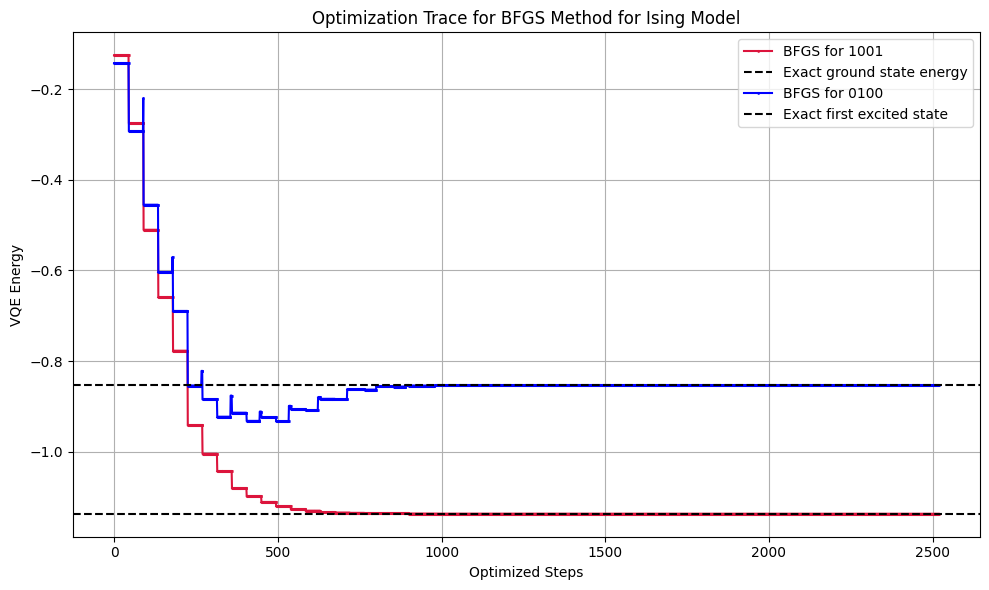

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming stack, job_theta, and job_funct are already defined

# Plot the optimization trace for BFGS from job_theta
res_theta = stack.submit(job_theta)
vals_U = res_theta.meta_data["optimization_trace"]
trace_U = eval(vals_U)
trace_U = trace_U[:3500]
xlist_U = res_theta.value

# Plot the optimization trace for BFGS from job_funct
res_funct = stack.submit(job_funct)
vals_UV = res_funct.meta_data["optimization_trace"]
trace_UV = eval(vals_UV)

res_cost_exci_1 = xlist_U - 0.25 * xlist_UV
trace_cost_exci_1 = [u - 0.25 * v for u, v in zip(trace_U, trace_UV[:len(trace_U)])]


plt.figure(figsize=(10, 6))

# Plot the trace from job_theta with color 'crimson'
plt.plot(
    trace_U,
    lw=1.5,
    label="BFGS for 1001",
    color='crimson',
    linestyle='solid',
    marker='3',
    markersize=2.2
)


plt.axhline(xlist_U, color='black', linestyle='--', label="Exact ground state energy")

# Plot the trace from job_funct with color 'blue'
plt.plot(
    trace_cost_exci_1,
    lw=1.5,
    label="BFGS for 0100",
    color='blue',
    linestyle='solid',
    marker='3',
    markersize=2.2
)

plt.axhline(res_cost_exci_1, color='black', linestyle='--', label="Exact first excited state")



plt.xlabel("Optimized Steps")
plt.ylabel("VQE Energy")
plt.legend()
plt.grid(True)
plt.title("Optimization Trace for BFGS Method for Ising Model")
plt.tight_layout()
plt.show()



#### Make the third excited state and compared

In [44]:
n_rotations = 2
nqbits = 4
n_cycles =3 # this is for V
n_layers = 3 # this is for U
k_targ = 13

phi_0 = [np.random.uniform(0, 2*np.pi) for i in range(n_rotations * (nqbits + 2 * (nqbits - 1) * n_cycles))]
print("Value that will be distribute to all the indicator of phi as applied state are :", phi_0)

theta_update = ylist_U

circ_funct_1 = UV_function(4, phi_0, theta_update, 13, 3, 3, [RX, RZ], CNOT)

circ_funct_1.display()

Value that will be distribute to all the indicator of phi as applied state are : [1.2467966029590418, 3.861788429688576, 0.7656013956001476, 4.165364495260686, 2.057550194075108, 3.5132837902926006, 1.8915012163296265, 4.077866306447486, 0.3839018912303198, 5.9069718825507564, 2.7908605149305306, 6.123663244608413, 3.4759187322425995, 0.7746832127642749, 1.8383418239484834, 4.244646705499896, 2.4319635314976207, 3.7631588049411815, 1.4954357273354009, 0.4674717984160091, 2.012231625403473, 0.29840480574791073, 5.608452235138919, 5.755341698866309, 4.039168636848744, 1.0851186221877767, 3.914731185867736, 4.195984821881967, 0.968965066577857, 2.4291973762270294, 5.417292140003483, 2.2272292479616436, 2.9849852301513184, 4.775540412728569, 3.7472745775454435, 3.5908565705445104, 4.961088057049717, 5.8132995284117905, 2.8208991337160696, 5.595799196887377, 1.8749205231571977, 0.045375788144926196, 1.6340170681156674, 4.614165300766441]
This target state is  1101


In [45]:
import numpy
from qat.vsolve.optimize import ScipyMinimizePlugin
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qat.qpus import get_default_qpu


Optimizer = ScipyMinimizePlugin( method="BFGS", 
                                 x0 = list_UV,
                                 tol=1e-6,
                                 options={"maxiter": 200, "disp": True},
                                 )

qpu = get_default_qpu()
stack = Optimizer | qpu



job_funct_1 = circ_funct_1.to_job(job_type="OBS",
                  observable=model,
                  nbshots=0)

res_funct_1 = stack.submit(job_funct_1)



# Define termms for the measurments

xlist_UV_1 = res_funct_1.value
ylist_UV_1 = res_funct_1.meta_data["parameters"]
vals_UV_1 = res_funct_1.meta_data["optimization_trace"]
trace_UV_1 = eval(vals_UV_1)
data_UV_1 =  res_funct_1.meta_data["optimizer_data"]

# Define termms for the measurments

print("Optimization energy Result:", xlist_UV_1)
print("The optimization data:", data_UV_1)
print("Theta optimization updated", ylist_UV_1)
print("Evaluated energy for each optimized step",trace_UV_1)

# Actually everything is in the optimizer_data

Optimization terminated successfully.
         Current function value: -1.137270
         Iterations: 28
         Function evaluations: 2848
         Gradient evaluations: 32
Optimization energy Result: -1.1372701746593987
The optimization data:   message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -1.1372701746593987
        x: [ 1.108e+00 -1.349e-01 ... -1.950e-07  5.015e-01]
      nit: 28
      jac: [ 1.490e-08 -1.490e-08 ...  8.941e-08 -2.980e-08]
 hess_inv: [[ 1.072e+00 -6.362e-03 ... -4.767e-02  9.695e-02]
            [-6.362e-03  9.220e-01 ... -1.340e-02 -6.160e-03]
            ...
            [-4.767e-02 -1.340e-02 ...  2.712e+00 -2.845e-02]
            [ 9.695e-02 -6.160e-03 ... -2.845e-02  1.090e+00]]
     nfev: 2848
     njev: 32
Theta optimization updated [1.1082722246491563, -0.13491516147842342, -0.014507164880409141, 0.8280909277789312, 0.24082378365983423, 0.45234685506441774, 0.9586413998952952, 0.2614834892586206, 0.4130160154749487,

In [46]:
res_cost_exci_2 = xlist_U - 0.25 * xlist_UV - 0.25 * xlist_UV_1
trace_cost_exci_2 = [u - 0.25 * v - 0.25 * v1 for u, v, v1 in zip(trace_U, trace_UV[:len(trace_U)], trace_UV_1[:len(trace_U)] )]

Optimization terminated successfully.
         Current function value: -1.137270
         Iterations: 45
         Function evaluations: 2115
         Gradient evaluations: 47
Optimization terminated successfully.
         Current function value: -1.137270
         Iterations: 29
         Function evaluations: 2759
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: -1.137270
         Iterations: 33
         Function evaluations: 3115
         Gradient evaluations: 35


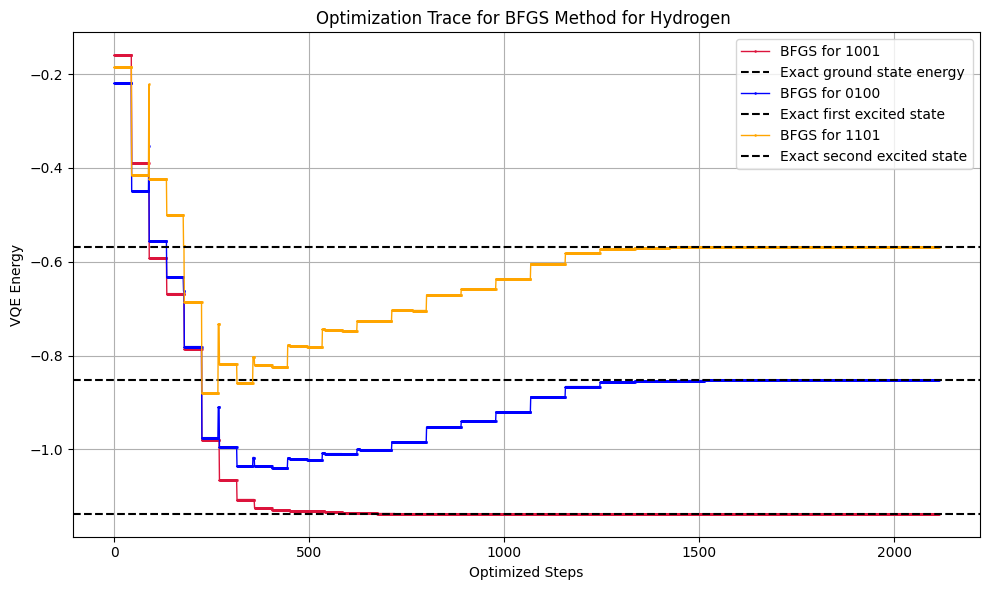

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming stack, job_theta, and job_funct are already defined

# Plot the optimization trace for BFGS from job_theta

res_theta = stack.submit(job_theta)
vals_U = res_theta.meta_data["optimization_trace"]
trace_U = eval(vals_U)
trace_U = trace_U[:3500]
xlist_U = res_theta.value

# Plot the optimization trace for BFGS from job_funct 1st exci
res_funct = stack.submit(job_funct)
vals_UV = res_funct.meta_data["optimization_trace"]
trace_UV = eval(vals_UV)

res_cost_exci_1 = xlist_U - 0.25 * xlist_UV
trace_cost_exci_1 = [u - 0.25 * v for u, v in zip(trace_U, trace_UV[:len(trace_U)])]

# Plot the optimization trace for BFGS from job_funct 2nd exci

res_funct_1 = stack.submit(job_funct_1)
vals_UV_1 = res_funct_1.meta_data["optimization_trace"]
trace_UV_1 = eval(vals_UV_1)

res_cost_exci_2 = xlist_U - 0.25 * xlist_UV - 0.25 * xlist_UV_1
trace_cost_exci_2 = [u - 0.25 * v - 0.25 * v1 for u, v, v1 in zip(trace_U, trace_UV[:len(trace_U)], trace_UV_1[:len(trace_U)] )]



plt.figure(figsize=(10, 6))

# Plot the trace from job_theta with color 'crimson'
plt.plot(
    trace_U,
    lw=1,
    label="BFGS for 1001",
    color='crimson',
    linestyle='solid',
    marker='3',
    markersize=2
)


plt.axhline(xlist_U, color='black', linestyle='--', label="Exact ground state energy")

# Plot the trace from job_funct with color 'blue'
plt.plot(
    trace_cost_exci_1,
    lw=1,
    label="BFGS for 0100",
    color='blue',
    linestyle='solid',
    marker='3',
    markersize=2
)

plt.axhline(res_cost_exci_1, color='black', linestyle='--', label="Exact first excited state")

plt.plot(
    trace_cost_exci_2,
    lw=1,
    label="BFGS for 1101",
    color='orange',
    linestyle='solid',
    marker='3',
    markersize=2
)

plt.axhline(res_cost_exci_2, color='black', linestyle='--', label="Exact second excited state")


plt.xlabel("Optimized Steps")
plt.ylabel("VQE Energy")
plt.legend()
plt.grid(True)
plt.title("Optimization Trace for BFGS Method for Hydrogen ")
plt.tight_layout()
plt.show()

#### Make the third excited state

In [48]:
n_rotations = 2
nqbits = 4
n_cycles =3 # this is for V
n_layers = 3 # this is for U
k_targ = 6

phi_0 = [np.random.uniform(0, 2*np.pi) for i in range(n_rotations * (nqbits + 2 * (nqbits - 1) * n_cycles))]
print("Value that will be distribute to all the indicator of phi as applied state are :", phi_0)

theta_update = ylist_U

circ_funct_2 = UV_function(4, phi_0, theta_update, 6, 3, 3, [RX, RZ], CNOT)

circ_funct_2.display()

Value that will be distribute to all the indicator of phi as applied state are : [5.011265373916206, 1.0155485289346982, 3.115280520551069, 2.5947060839656872, 2.961395622106565, 1.9622321657159478, 6.224216758087282, 5.478100576305761, 5.144657104635054, 1.8287184176780575, 3.571605718780761, 1.4891084653661688, 4.6106054469661, 3.9210057992286633, 5.944238799925862, 2.472651662302098, 1.6373963105887799, 0.8938405414985758, 6.217155821794539, 3.3636297698204722, 5.490405469532528, 3.1256621982151804, 4.720901603538651, 1.9377783713616228, 0.9284763848744807, 2.14245270997396, 2.8177686391553842, 2.2784736316281853, 4.751293374601715, 4.550572424808314, 3.6564048119361057, 3.9417634961497576, 1.7811879457603417, 3.980082145192095, 4.873791377080923, 2.982661155648212, 5.723756154540182, 2.023383648870414, 4.021394508341116, 5.724507969876309, 0.9706492806415896, 4.731774460917375, 2.5298738675389423, 1.7238137085663852]
This target state is  0110


In [49]:
import numpy
from qat.vsolve.optimize import ScipyMinimizePlugin
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qat.qpus import get_default_qpu


Optimizer = ScipyMinimizePlugin( method="BFGS", 
                                 x0 = list_UV,
                                 tol=1e-6,
                                 options={"maxiter": 200, "disp": True},
                                 )

qpu = get_default_qpu()
stack = Optimizer | qpu



job_funct_2 = circ_funct_2.to_job(job_type="OBS",
                  observable=model,
                  nbshots=0)

res_funct_2 = stack.submit(job_funct_2)



# Define termms for the measurments

xlist_UV_2 = res_funct_2.value
ylist_UV_2 = res_funct_2.meta_data["parameters"]
vals_UV_2 = res_funct_2.meta_data["optimization_trace"]
trace_UV_2 = eval(vals_UV_2)
data_UV_2 =  res_funct_2.meta_data["optimizer_data"]

# Define termms for the measurments

print("Optimization energy Result:", xlist_UV_2)
print("The optimization data:", data_UV_2)
print("Theta optimization updated", ylist_UV_2)
print("Evaluated energy for each optimized step",trace_UV_2)

# Actually everything is in the optimizer_data

Optimization terminated successfully.
         Current function value: -1.137270
         Iterations: 43
         Function evaluations: 4005
         Gradient evaluations: 45
Optimization energy Result: -1.1372701746596294
The optimization data:   message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -1.1372701746596294
        x: [ 2.828e-01  1.559e-01 ... -2.157e+00  9.686e-02]
      nit: 43
      jac: [ 1.490e-07 -1.490e-07 ... -1.788e-07  5.960e-08]
 hess_inv: [[ 1.164e+00 -1.478e-01 ...  9.470e-02  7.096e-02]
            [-1.478e-01  1.251e+00 ... -3.595e-02 -7.775e-02]
            ...
            [ 9.470e-02 -3.595e-02 ...  1.344e+00  1.613e-01]
            [ 7.096e-02 -7.775e-02 ...  1.613e-01  1.002e+00]]
     nfev: 4005
     njev: 45
Theta optimization updated [0.2828041526730885, 0.15585562638055558, 0.7793014057938263, 0.49227986287292197, 0.8152785080855934, 0.30079867504230395, 0.1279973499073378, 0.9512336937310876, 0.3551486824494555, 0.8

In [50]:
res_cost_exci_3 = xlist_U - 0.25 * xlist_UV - 0.25 * xlist_UV_1 - 0.25 * xlist_UV_2
trace_cost_exci_3 = [u - 0.25 * v - 0.25 * v1 - 0.25 * v2 for u, v, v1, v2 in zip(trace_U, trace_UV[:len(trace_U)], trace_UV_1[:len(trace_U)], trace_UV_2[:len(trace_U)] )]

Optimization terminated successfully.
         Current function value: -1.137270
         Iterations: 67
         Function evaluations: 3105
         Gradient evaluations: 69
Optimization terminated successfully.
         Current function value: -1.137270
         Iterations: 32
         Function evaluations: 2937
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: -1.137270
         Iterations: 43
         Function evaluations: 4094
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: -1.137270
         Iterations: 40
         Function evaluations: 3916
         Gradient evaluations: 44


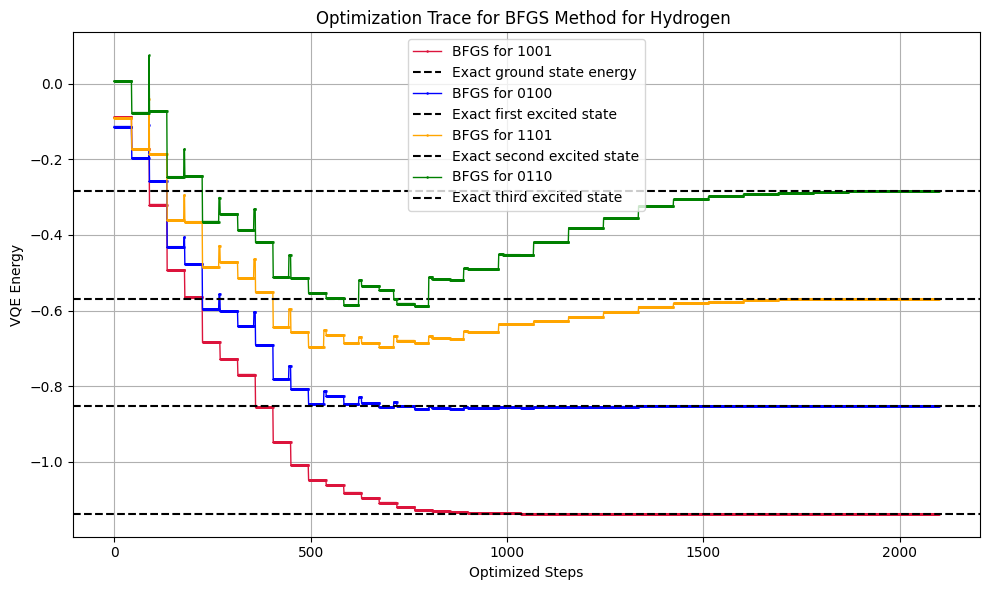

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming stack, job_theta, and job_funct are already defined

# Plot the optimization trace for BFGS from job_theta

res_theta = stack.submit(job_theta)
vals_U = res_theta.meta_data["optimization_trace"]
trace_U = eval(vals_U)
trace_U = trace_U[:2100]
xlist_U = res_theta.value

# Plot the optimization trace for BFGS from job_funct 1st exci
res_funct = stack.submit(job_funct)
vals_UV = res_funct.meta_data["optimization_trace"]
trace_UV = eval(vals_UV)

res_cost_exci_1 = xlist_U - 0.25 * xlist_UV
trace_cost_exci_1 = [u - 0.25 * v for u, v in zip(trace_U, trace_UV[:len(trace_U)])]

# Plot the optimization trace for BFGS from job_funct 2nd exci

res_funct_1 = stack.submit(job_funct_1)
vals_UV_1 = res_funct_1.meta_data["optimization_trace"]
trace_UV_1 = eval(vals_UV_1)

res_cost_exci_2 = xlist_U - 0.25 * xlist_UV - 0.25 * xlist_UV_1
trace_cost_exci_2 = [u - 0.25 * v - 0.25 * v1 for u, v, v1 in zip(trace_U, trace_UV[:len(trace_U)], trace_UV_1[:len(trace_U)] )]

# Plot the optimization trace for BFGS from job_funct 3nd exci

res_funct_2 = stack.submit(job_funct_2)
vals_UV_2 = res_funct_2.meta_data["optimization_trace"]
trace_UV_2 = eval(vals_UV_2)

res_cost_exci_3 = xlist_U - 0.25 * xlist_UV - 0.25 * xlist_UV_1 - 0.25 * xlist_UV_2
trace_cost_exci_3 = [u - 0.25 * v - 0.25 * v1 - 0.25 * v2 for u, v, v1, v2 in zip(trace_U, trace_UV[:len(trace_U)], trace_UV_1[:len(trace_U)], trace_UV_2[:len(trace_U)] )]


plt.figure(figsize=(10, 6))

# Plot the trace from job_theta with color 'crimson'
plt.plot(
    trace_U,
    lw=1,
    label="BFGS for 1001",
    color='crimson',
    linestyle='solid',
    marker='3',
    markersize=2
)


plt.axhline(xlist_U, color='black', linestyle='--', label="Exact ground state energy")

# Plot the trace from job_funct with color 'blue'
plt.plot(
    trace_cost_exci_1,
    lw=1,
    label="BFGS for 0100",
    color='blue',
    linestyle='solid',
    marker='3',
    markersize=2
)

plt.axhline(res_cost_exci_1, color='black', linestyle='--', label="Exact first excited state")

plt.plot(
    trace_cost_exci_2,
    lw=1,
    label="BFGS for 1101",
    color='orange',
    linestyle='solid',
    marker='3',
    markersize=2
)

plt.axhline(res_cost_exci_2, color='black', linestyle='--', label="Exact second excited state")


plt.plot(
    trace_cost_exci_3,
    lw=1,
    label="BFGS for 0110",
    color='green',
    linestyle='solid',
    marker='3',
    markersize=2
)

plt.axhline(res_cost_exci_3, color='black', linestyle='--', label="Exact third excited state")

plt.xlabel("Optimized Steps")
plt.ylabel("VQE Energy")
plt.legend()
plt.grid(True)
plt.title("Optimization Trace for BFGS Method for Hydrogen ")
plt.tight_layout()
plt.show()